In [1]:
__authors__ = "Anton Gochev, Jaro Habr, Yan Jiang, Samuel Kahn"
__version__ = "XCS224u, Stanford, Spring 2021"

## Contents

1. [Setup](#Setup)
1. [Dataset](#Dataset)
1. [Baseline-System](#Baseline-System)
1. [Experiments](#Experiments)
  1. [Transformers](#Transformers)
  1. [GPT-3: Few-Short-Learning](#GPT-3:-Few-Shot-Learning)

## Setup

In [1]:
from colors import ColorsCorpusReader
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch_color_describer import ContextualColorDescriber, create_example_dataset
import utils
from utils import UNK_SYMBOL
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch
import numpy as np
from baseline import (
    BaselineTokenizer, BaselineColorEncoder,
    BaselineEmbedding, BaselineDescriber, GloVeEmbedding
)

## Dataset

This exploration of the dataset counts the examples for different classes and plots the words distribition in order to see any data imbalance issues.

In [2]:
COLORS_SRC_FILENAME = os.path.join(
    "data", "colors", "filteredCorpus.csv"
)

In [3]:
corpus = ColorsCorpusReader(
    COLORS_SRC_FILENAME,
    word_count=None,
    normalize_colors=True
)

In [4]:
examples = list(corpus.read())

In [5]:
len(examples)

46994

In [6]:
close_examples = [example for example in examples if example.condition == "close"]
split_examples = [example for example in examples if example.condition == "split"]
far_examples = [example for example in examples if example.condition == "far"]

In [7]:
print(f"close: {len(close_examples)}")
print(f"split: {len(split_examples)}")
print(f"close: {len(close_examples)}")

 close: 15519
 split: 15693
 close: 15519


<BarContainer object of 3 artists>

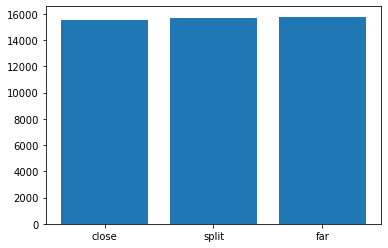

In [8]:
plt.bar(
    np.arange(3),
    height=[len(close_examples), len(split_examples), len(far_examples)],
    tick_label = ['close','split','far']
)

### Number of words used for description

In [9]:
description_words = dict()
description_words_sorted = dict()
tokenizer = BaselineTokenizer()

for example in examples:
    words = tokenizer.encode(example.contents) # use content tokenizer
    description_length = len(words) - 2 # don't count start and end symbols
    
    if description_length in description_words.keys():
        description_words[description_length] += 1
    else:
        description_words[description_length] = 1
        
for key in sorted(description_words):
    description_words_sorted[key] = description_words[key]
        
assert np.sum(list(description_words_sorted.values())) == len(examples)

In [10]:
description_words_sorted

{1: 19160,
 2: 12195,
 3: 4055,
 4: 2872,
 5: 2175,
 6: 1697,
 7: 1218,
 8: 882,
 9: 681,
 10: 495,
 11: 404,
 12: 307,
 13: 241,
 14: 214,
 15: 86,
 16: 52,
 17: 47,
 18: 35,
 19: 31,
 20: 36,
 21: 27,
 22: 17,
 23: 13,
 24: 5,
 25: 12,
 26: 3,
 27: 5,
 28: 5,
 29: 2,
 30: 1,
 31: 1,
 32: 4,
 33: 5,
 34: 1,
 35: 3,
 36: 2,
 37: 1,
 39: 1,
 41: 1,
 44: 1,
 53: 1}

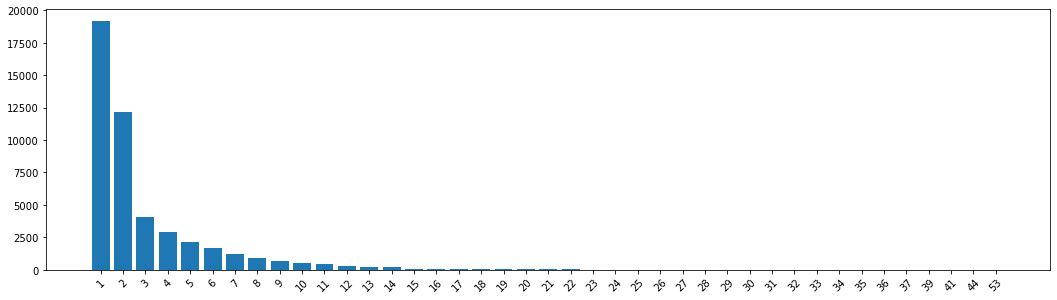

In [11]:
plt.figure(figsize=(18, 4.8))
plt.bar(
    np.arange(len(list(description_words_sorted.keys()))),
    height=list(description_words_sorted.values()),
    tick_label=list(description_words_sorted.keys())
)
plt.xticks(rotation=45)
plt.show()

## Baseline-System

This baseline system is based on assignment 4.

In [12]:
tokenizer = BaselineTokenizer()
color_encoder = BaselineColorEncoder()
embedding = BaselineEmbedding()

### Tiny dataset - baseline system development

The tiny dataset is used for baseline model development and fast testing.

In [28]:
def create_dev_data():
    dev_color_seqs, dev_word_seqs, dev_vocab = create_example_dataset(
        group_size=50,
        vec_dim=2
    )

    dev_colors_train, dev_colors_test, dev_words_train, dev_words_test = \
        train_test_split(dev_color_seqs, dev_word_seqs)
    
    return dev_vocab, dev_colors_train, dev_words_train, dev_colors_test, dev_words_test

In [29]:
dev_vocab, dev_colors_train, dev_tokens_train, dev_colors_test, dev_texts_test = \
    create_dev_data()

In [30]:
dev_glove_embedding, dev_glove_vocab = embedding.create_glove_embedding(dev_vocab)

In [32]:
dev_baseline_model = BaselineDescriber(
    dev_glove_vocab,
    embedding=dev_glove_embedding,
    early_stopping=True
)

In [33]:
%time _ = dev_baseline_model.fit(toy_colors_train, toy_tokens_train)

Stopping after epoch 23. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 1.3588870763778687

CPU times: user 1.22 s, sys: 132 ms, total: 1.35 s
Wall time: 1.38 s


In [34]:
dev_baseline_model.evaluate(toy_colors_test, toy_texts_test)

{'listener_accuracy': 0.47368421052631576, 'corpus_bleu': 0.62819020717699}

### Full dataset - model training

The full color context dataset is used for final baseline model training.

In [24]:
def create_data():    
    rawcols, texts = zip(*[[ex.colors, ex.contents] for ex in examples])

    raw_colors_train, raw_colors_test, texts_train, texts_test = \
        train_test_split(rawcols, texts)

    tokens_train = [tokenizer.encode(text) for text in texts_train]
    colors_train = [
        color_encoder.encode_color_context(colors) for colors in raw_colors_train
    ]

    vocab = sorted({word for tokens in tokens_train for word in tokens})
    vocab += [UNK_SYMBOL]

    return vocab, colors_train, tokens_train, raw_colors_test, texts_test

In [26]:
vocab, colors_train, tokens_train, raw_colors_test, texts_test = create_data()

In [27]:
glove_embedding, glove_vocab = embedding.create_glove_embedding(vocab)

In [22]:
baseline_model = BaselineDescriber(
    glove_vocab,
    embedding=glove_embedding,
    early_stopping=True
)

In [ ]:
%time _ = baseline_model.fit(colors_train, tokens_train)

In [19]:
def evaluate(trained_model, color_seqs_test, texts_test):
    tok_seqs = [tokenizer.encode(text) for text in texts_test]
    col_seqs = [color_encoder.encode_color_context(colors) for colors in color_seqs_test]

    return trained_model.evaluate(col_seqs, tok_seqs)

In [20]:
evaluate(baseline_model, raw_colors_test, texts_test)

{'listener_accuracy': 0.7403183249638267, 'corpus_bleu': 0.4498756333938617}

## Experiments

### Transformers

In [21]:
# transformers experiments

### GPT-3: Few-Shot-Learning

This section compares the GPT-3 performance with the baseline system as well as the transformer section. GPT-3 uses system conditioning with zero-shot or few-short learning.


Q: Describe the target color of [[131, 154, 100], [163, 90, 164], [135, 211, 43]].
A: lime.

Q: Describe the target color of [[98, 156, 116], [212, 25, 229], [130, 138, 116]].
A: Mud brown.

Q: Describe the target color of [[112, 142, 129], [177, 253, 1], [115, 147, 107]].
A: Camo green.

Q: Describe the target color of [[219, 96, 35], [47, 194, 207], [184, 79, 70]].
A: Darkish red.

Q: Describe the target color of [[132, 125, 122], [160, 62, 192], [136, 146, 108]].
A: One of the brown ones, the lighter shaded one.

Q: Describe the target color of [[138, 104, 150], [69, 202, 52], [149, 105, 141]].
A: The more vibrantly red one... not the more purple one.

Q: Describe the target color of [[106, 172, 82], [223, 31, 210], [118, 137, 117]].
A: Like that description? Haha ### Thank you. ### Grey.

Q: Describe the target color of [[84, 170, 120], [179, 75, 85], [106, 154, 100]].
A: Camo green.

Q: Describe the target color of [[133, 123, 121], [253, 177, 1], [127, 130, 124]].
A: oopsies. I 

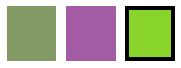

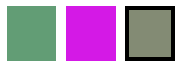

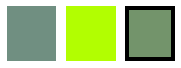

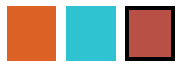

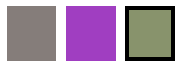

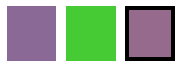

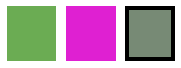

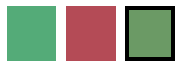

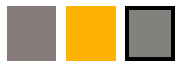

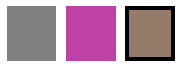

In [23]:
# some more experiment with GPT-3 maybe to compare with few-shot-learning

# conditioning sequence:
#I am a highly intelligent question answering bot that can describe colors with human readable text as precisely as possible. Given an array of three context colors with their RGB (red, green, blue) values, describe the target color in such a way that a human could recognize the target color even if the colors were reordered. The target color is the last color in the array.

for example in (split_examples + close_examples)[:10]:
    print(f"\nQ: Describe the target color of {example.rgb_colors()}.")
    print(f"A: {example.contents}.")
    example.display(print_contents=False)